# Session 3 — Sentence-Level Analysis
## Measure 3: Sentence Embeddings (LLMs as Semantic Encoders)
### BONUS: Comparative Analysis of PetSemetary and TheShining

> **Note:** This is an **advanced extension** of notebook `3_1_AppliedNLP_Session3_Sentence_Embeddings.ipynb`. 
> Complete the basic notebook first to understand the fundamentals of sentence embeddings before working through this more complex literary analysis.

---

### What This Bonus Notebook Covers
This advanced demonstration applies sentence embeddings to **real literary texts**, analyzing Stephen King's two PetSemetary books:
- Extracts and compares key sentences from both novels
- Performs multi-dimensional visualization (2D, 3D)
- Automatically discovers thematic clusters
- Quantifies cross-book semantic similarities
- Provides comparative literary analysis

### Prerequisites
Before starting this notebook, you should:
- Complete notebook `3_1` and understand basic sentence embeddings
- Be familiar with PCA (Principal Component Analysis)
- Understand cosine similarity metrics
- Have the PetSemetary books in the `../data/` folder

---

### Quick Review: What are Sentence Embeddings?
Sentence embeddings are **dense vector representations** of sentences that capture their semantic meaning in a high-dimensional space. Unlike traditional word-based approaches, sentence embeddings encode the entire meaning of a sentence into a single fixed-length vector (typically 384-768 dimensions).

### How They Work
Modern sentence embedding models (like SBERT - Sentence-BERT) use **transformer architectures** pre-trained on massive text corpora. These models:
- Convert sentences into numerical vectors where semantically similar sentences are close together in vector space
- Capture context, syntax, and semantic relationships
- Enable comparison of sentences based on meaning rather than just word overlap

### Key Applications in NLP
1. **Semantic Similarity**: Measure how similar two sentences are in meaning
2. **Information Retrieval**: Find relevant documents or passages based on semantic search
3. **Text Clustering**: Group similar sentences or documents together
4. **Duplicate Detection**: Identify paraphrases or semantically identical content
5. **Question Answering**: Match questions with relevant answers
6. **Content Recommendation**: Suggest similar content based on semantic understanding
7. **Comparative Literary Analysis**: Compare themes, writing styles, and narrative patterns across texts

### This Advanced Demonstration
We'll use the **all-MiniLM-L6-v2** model to:
- Extract key sentences from both PetSemetary books using extractive summarization
- Encode sentences into semantic vectors
- Visualize thematic relationships between the two books in 2D/3D space
- Identify semantic similarities and differences between the narratives
- Cluster sentences by themes (e.g., size changes, absurdity, dialogue, fantasy)
- Perform quantitative comparative literature analysis

In [10]:

from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import re
import nltk
from collections import Counter

# Ensure NLTK punkt is available
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

print("✓ NLTK tokenizer ready!")


✓ NLTK tokenizer ready!


In [11]:
def load_book(filepath):
    """Load and (optionally) clean book text."""
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()
    
    # These markers won't harm if not present in your files
    start_markers = ['*** START OF', 'CHAPTER I']
    end_markers = ['*** END OF', 'End of Project Gutenberg']
    
    for marker in start_markers:
        if marker in text:
            start = text.find(marker)
            if marker == 'CHAPTER I':
                text = text[start:]
            else:
                text = text[start + len(marker):]
            break

    for marker in end_markers:
        if marker in text:
            end = text.find(marker)
            text = text[:end]
            break

    return text

PetSemetary_text = load_book('../data/PetSemetary.txt')
TheShining_text   = load_book('../data/TheShining.txt')

print(f"PetSemetary: {len(PetSemetary_text):,} characters")
print(f"TheShining: {len(TheShining_text):,} characters")


PetSemetary: 812,517 characters
TheShining: 906,176 characters


In [12]:
def extract_key_sentences(text, n_sentences=30):
    # Explicitly use English
    sentences = nltk.sent_tokenize(text, language="english")

    filtered = []
    for sent in sentences:
        sent = " ".join(sent.split())  # normalize spaces
        wc = len(sent.split())
        if wc < 8 or wc > 40:
            continue
        if sent.startswith("CHAPTER"):
            continue
        if re.match(r"^[IVX]+\.", sent):
            continue
        filtered.append(sent)
    
    # simple scoring heuristic
    scores = []
    for sent in filtered:
        score = 0
        if '"' in sent: score += 2
        if '?' in sent: score += 1
        if '!' in sent: score += 1
        wc = len(sent.split())
        if 12 <= wc <= 25: score += 1
        scores.append(score)
    
    ranked = sorted(zip(filtered, scores), key=lambda x: x[1], reverse=True)
    selected = []
    for s, sc in ranked[:n_sentences*2]:
        if s not in selected:
            selected.append(s)
        if len(selected) >= n_sentences:
            break
    return selected

n = 25
PetSemetary_sentences = extract_key_sentences(PetSemetary_text, n)
TheShining_sentences  = extract_key_sentences(TheShining_text, n)

print(f"Extracted {len(PetSemetary_sentences)} Pet Semetary sentences")
print(f"Extracted {len(TheShining_sentences)} The Shining sentences")
print(f"\nTotal: {len(PetSemetary_sentences) + len(TheShining_sentences)} sentences")


Extracted 25 Pet Semetary sentences
Extracted 25 The Shining sentences

Total: 50 sentences


In [13]:
print("\nLoading model...")
model = SentenceTransformer("all-MiniLM-L6-v2")

all_sentences = PetSemetary_sentences + TheShining_sentences
book_labels   = ["PetSemetary"] * len(PetSemetary_sentences) + \
                ["TheShining"] * len(TheShining_sentences)

print("Encoding...")
embeddings = model.encode(all_sentences, show_progress_bar=True)

PetSemetary_embeddings = embeddings[:len(PetSemetary_sentences)]
TheShining_embeddings  = embeddings[len(PetSemetary_sentences):]

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(embeddings)

print("\nCluster distribution:")
book_labels_np = np.array(book_labels)
for i in range(n_clusters):
    total = np.sum(clusters == i)
    pet   = np.sum((clusters == i) & (book_labels_np == "PetSemetary"))
    shine = np.sum((clusters == i) & (book_labels_np == "TheShining"))
    print(f"Cluster {i}: {total} (PetSemetary={pet}, TheShining={shine})")


Loading model...
Encoding...


Batches: 100%|██████████| 2/2 [00:00<00:00,  8.77it/s]


Cluster distribution:
Cluster 0: 11 (PetSemetary=9, TheShining=2)
Cluster 1: 8 (PetSemetary=1, TheShining=7)
Cluster 2: 13 (PetSemetary=5, TheShining=8)
Cluster 3: 10 (PetSemetary=4, TheShining=6)
Cluster 4: 8 (PetSemetary=6, TheShining=2)


In [14]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(embeddings)

print("\nCluster distribution:")
for i in range(n_clusters):
    total = sum(clusters == i)
    pet   = sum((clusters == i) & (np.array(book_labels) == "PetSemetary"))
    shine = sum((clusters == i) & (np.array(book_labels) == "TheShining"))
    print(f"Cluster {i}: {total} (PetSemetary={pet}, TheShining={shine})")


Cluster distribution:
Cluster 0: 11 (PetSemetary=9, TheShining=2)
Cluster 1: 8 (PetSemetary=1, TheShining=7)
Cluster 2: 13 (PetSemetary=5, TheShining=8)
Cluster 3: 10 (PetSemetary=4, TheShining=6)
Cluster 4: 8 (PetSemetary=6, TheShining=2)


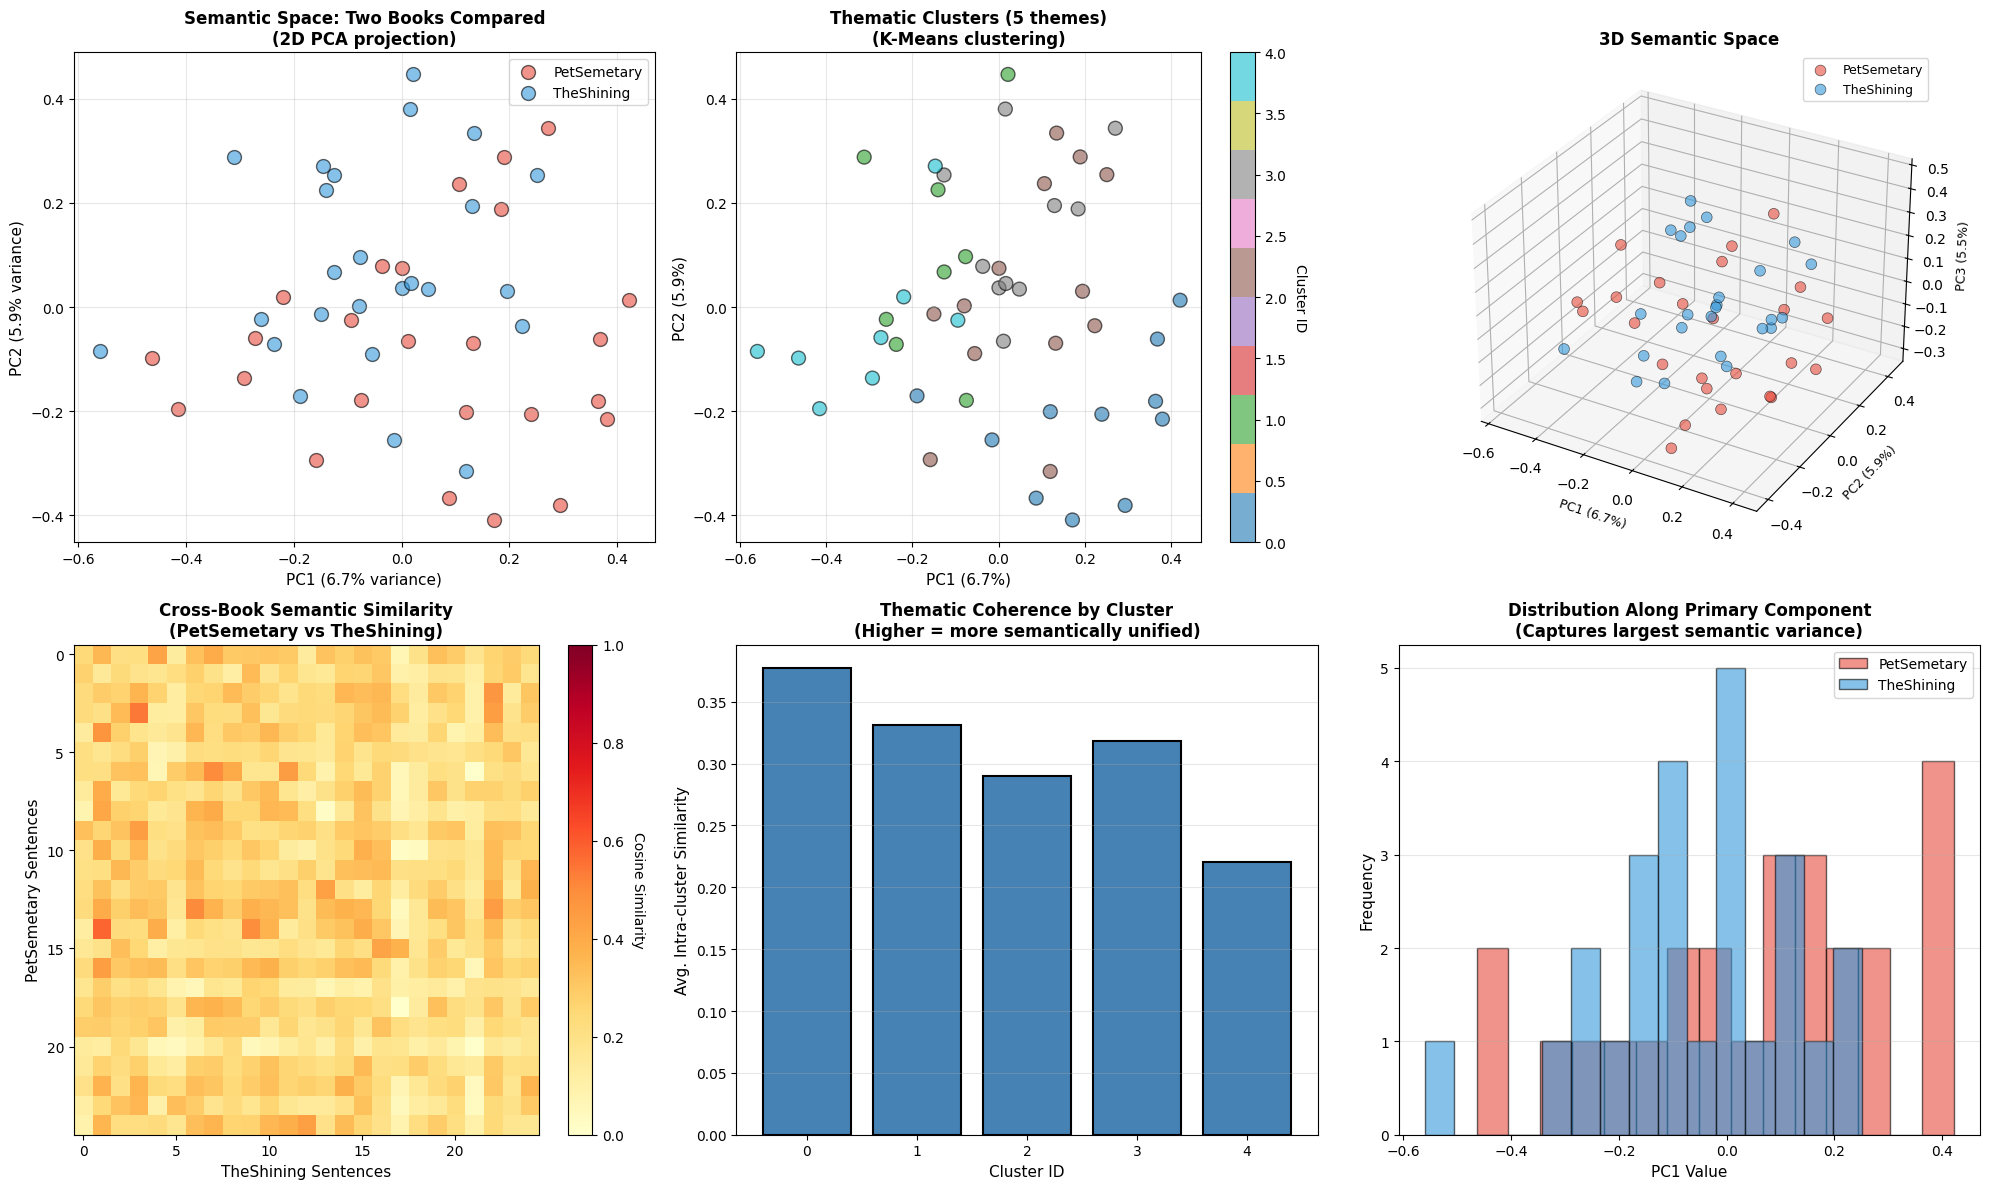

In [15]:
fig = plt.figure(figsize=(20, 12))

colors_dict = {'PetSemetary': '#e74c3c', 'TheShining': '#3498db'}
colors = [colors_dict[label] for label in book_labels]

# --- Plot 1: 2D PCA with book distinction ---
ax1 = plt.subplot(2, 3, 1)
pca_2d = PCA(n_components=2)
points_2d = pca_2d.fit_transform(embeddings)

for book in ['PetSemetary', 'TheShining']:
    mask = book_labels_np == book
    ax1.scatter(points_2d[mask, 0], points_2d[mask, 1], 
                c=colors_dict[book], label=book,
                alpha=0.6, s=100, edgecolors='black', linewidth=1)

ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax1.set_title('Semantic Space: Two Books Compared\n(2D PCA projection)', fontsize=12, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# --- Plot 2: 2D PCA with clusters ---
ax2 = plt.subplot(2, 3, 2)
scatter = ax2.scatter(points_2d[:, 0], points_2d[:, 1], c=clusters, 
                      cmap='tab10', alpha=0.6, s=100, edgecolors='black', linewidth=1)
ax2.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})', fontsize=11)
ax2.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})', fontsize=11)
ax2.set_title(f'Thematic Clusters ({n_clusters} themes)\n(K-Means clustering)', 
              fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Cluster ID', rotation=270, labelpad=15)
ax2.grid(True, alpha=0.3)

# --- Plot 3: 3D PCA ---
ax3 = plt.subplot(2, 3, 3, projection='3d')
pca_3d = PCA(n_components=3)
points_3d = pca_3d.fit_transform(embeddings)

for book in ['PetSemetary', 'TheShining']:
    mask = book_labels_np == book
    ax3.scatter(points_3d[mask, 0], points_3d[mask, 1], points_3d[mask, 2],
                c=colors_dict[book], label=book,
                alpha=0.6, s=60, edgecolors='black', linewidth=0.5)

ax3.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})', fontsize=9)
ax3.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})', fontsize=9)
ax3.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})', fontsize=9)
ax3.set_title('3D Semantic Space', fontsize=12, fontweight='bold')
ax3.legend(loc='best', fontsize=9)

# --- Plot 4: Cross-book similarity matrix ---
ax4 = plt.subplot(2, 3, 4)

# Compute similarity between PetSemetary and TheShining
PetSemetary_embeddings = embeddings[:len(PetSemetary_sentences)]
TheShining_embeddings  = embeddings[len(PetSemetary_sentences):]
cross_similarity = util.cos_sim(PetSemetary_embeddings, TheShining_embeddings).numpy()

im = ax4.imshow(cross_similarity, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
cbar = plt.colorbar(im, ax=ax4)
cbar.set_label('Cosine Similarity', rotation=270, labelpad=15, fontsize=10)
ax4.set_xlabel('TheShining Sentences', fontsize=11)
ax4.set_ylabel('PetSemetary Sentences', fontsize=11)
ax4.set_title('Cross-Book Semantic Similarity\n(PetSemetary vs TheShining)', 
              fontsize=12, fontweight='bold')

# --- Plot 5: Average similarity per cluster ---
ax5 = plt.subplot(2, 3, 5)

cluster_similarities = []
for i in range(n_clusters):
    cluster_mask = clusters == i
    if np.sum(cluster_mask) > 1:
        cluster_emb = embeddings[cluster_mask]
        sim_matrix = util.cos_sim(cluster_emb, cluster_emb).numpy()
        # Average similarity (excluding diagonal)
        avg_sim = (sim_matrix.sum() - np.trace(sim_matrix)) / (sim_matrix.size - len(cluster_emb))
        cluster_similarities.append(avg_sim)
    else:
        cluster_similarities.append(0)

bars = ax5.bar(range(n_clusters), cluster_similarities, color='steelblue',
               edgecolor='black', linewidth=1.5)
ax5.set_xlabel('Cluster ID', fontsize=11)
ax5.set_ylabel('Avg. Intra-cluster Similarity', fontsize=11)
ax5.set_title('Thematic Coherence by Cluster\n(Higher = more semantically unified)', 
              fontsize=12, fontweight='bold')
ax5.set_xticks(range(n_clusters))
ax5.grid(True, alpha=0.3, axis='y')

# --- Plot 6: Distribution histogram ---
ax6 = plt.subplot(2, 3, 6)

PetSemetary_pc1  = points_2d[:len(PetSemetary_sentences), 0]
TheShining_pc1   = points_2d[len(PetSemetary_sentences):, 0]  # fixed index

ax6.hist(PetSemetary_pc1, bins=15, alpha=0.6, color='#e74c3c',
         label='PetSemetary', edgecolor='black')
ax6.hist(TheShining_pc1, bins=15, alpha=0.6, color='#3498db',
         label='TheShining', edgecolor='black')
ax6.set_xlabel('PC1 Value', fontsize=11)
ax6.set_ylabel('Frequency', fontsize=11)
ax6.set_title('Distribution Along Primary Component\n(Captures largest semantic variance)', 
              fontsize=12, fontweight='bold')
ax6.legend(loc='best')
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


### Interpreting the Visualizations

**Top Left - Book Comparison (2D):**
- Red points = PetSemetary
- Blue points = TheShining
- Spatial proximity indicates semantic similarity
- Overlapping regions suggest shared themes between books

**Top Middle - Thematic Clusters:**
- Color-coded by automatically detected themes
- K-Means clustering groups semantically similar sentences
- Reveals common narrative patterns across both books

**Top Right - 3D Semantic Space:**
- Three-dimensional view captures more variance
- Rotation would show different perspectives on semantic relationships
- Preserves more information than 2D projection

**Bottom Left - Cross-Book Similarity Matrix:**
- Heat map showing similarity between every PetSemetary sentence and every TheShining sentence
- Bright areas indicate highly similar passages
- Reveals which scenes/themes are shared across books

**Bottom Middle - Cluster Coherence:**
- Measures how semantically unified each theme cluster is
- Higher bars = sentences in that cluster are more similar to each other
- Indicates strength of thematic grouping

**Bottom Right - Distribution Analysis:**
- Shows how the books differ along the primary semantic dimension
- Overlapping distributions suggest similar semantic content
- Separated peaks would indicate distinct narrative styles

In [16]:
print("="*80)
print("THEMATIC ANALYSIS OF CLUSTERS")
print("="*80)

for cluster_id in range(n_clusters):
    cluster_mask = clusters == cluster_id
    cluster_sentences = [sent for sent, mask in zip(all_sentences, cluster_mask) if mask]
    cluster_books     = [book for book, mask in zip(book_labels, cluster_mask) if mask]
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}: {len(cluster_sentences)} sentences")
    print(f"  PetSemetary: {cluster_books.count('PetSemetary')}, "
          f"TheShining: {cluster_books.count('TheShining')}")
    print(f"{'='*80}")
    
    # Show representative sentences (up to 3)
    for i, (sent, book) in enumerate(zip(cluster_sentences[:3], cluster_books[:3]), 1):
        book_abbr = "PS" if book == "PetSemetary" else "TS"
        display_sent = sent if len(sent) < 100 else sent[:97] + "..."
        print(f"{i}. [{book_abbr}] {display_sent}")
    
    if len(cluster_sentences) > 3:
        print(f"   ... and {len(cluster_sentences) - 3} more sentences")


THEMATIC ANALYSIS OF CLUSTERS

CLUSTER 0: 11 sentences
  PetSemetary: 9, TheShining: 2
1. [PS] ‘Dreams are funny, aren’t they?’ ‘Dweems!’ Gage hollered—he had reached that parrot-stage that Lo...
2. [PS] ‘Louis, don’t hurt my father!’ ‘You like to hit old men, do you?’ Irwin Goldman of the overflowin...
3. [PS] Those people over there will think someone’s being murdered.’ ‘But it hurrrrts!’ Louis struggled ...
   ... and 8 more sentences

CLUSTER 1: 8 sentences
  PetSemetary: 1, TheShining: 7
1. [PS] Can’t you do something?’ ‘Got to get the stinger out,’ a voice behind them drawled.
2. [TS] "Was he the one who put the holes in our bug's tires?"
3. [TS] "Do you want to go and live in that hotel for the winter?"
   ... and 5 more sentences

CLUSTER 2: 13 sentences
  PetSemetary: 5, TheShining: 8
1. [PS] ‘You still want to see where yon path goes, Ellie?’ ‘Yes!’ Ellie said, getting up immediately.
2. [PS] She was jumping up and down on this, popping the blisters, and yelling, ‘He was my c

In [17]:
print("="*80)
print("MOST SIMILAR SENTENCES ACROSS BOOKS")
print("="*80)
print("Finding thematic parallels between PetSemetary and TheShining...\n")

PetSemetary_embeddings = embeddings[:len(PetSemetary_sentences)]
TheShining_embeddings  = embeddings[len(PetSemetary_sentences):]
cross_similarity = util.cos_sim(PetSemetary_embeddings, TheShining_embeddings).numpy()

pairs = []
for i in range(len(PetSemetary_sentences)):
    for j in range(len(TheShining_sentences)):
        pairs.append((i, j, cross_similarity[i, j]))

pairs.sort(key=lambda x: x[2], reverse=True)

for rank, (i, j, score) in enumerate(pairs[:5], 1):
    print(f"{rank}. Similarity: {score:.4f}")
    print(f"   [PetSemetary] {PetSemetary_sentences[i][:120]}...")
    print(f"   [TheShining]  {TheShining_sentences[j][:120]}...")
    print()


MOST SIMILAR SENTENCES ACROSS BOOKS
Finding thematic parallels between PetSemetary and TheShining...

1. Similarity: 0.5803
   [PetSemetary] ‘You,’ he said, ‘go to bed.’ ‘Doctor’s orders?’ she asked, smiling a little....
   [TheShining]  Sweeping her dress under her and sitting down on the curb beside him, she said: "What's up, doc?"...

2. Similarity: 0.5429
   [PetSemetary] ‘Louis, don’t hurt my father!’ ‘You like to hit old men, do you?’ Irwin Goldman of the overflowing checkbook cried out s...
   [TheShining]  "Did he hurt George Hatfield like the time I spilled all his papers?"...

3. Similarity: 0.5003
   [PetSemetary] Ellie had wandered away a little and now she said: ‘Daddy, what’s this?’ Louis, who had started to meet the moving men, ...
   [TheShining]  Danny was off the curb in a second, waving, jiving from one foot to the other, yelling: "Daddy!...

4. Similarity: 0.4996
   [PetSemetary] Or suppose he had fallen in the middle of the road instead of on the edge of it?...
   

In [18]:
# Analyze average within-book vs cross-book similarity
PetSemetary_sim = util.cos_sim(PetSemetary_embeddings, PetSemetary_embeddings).numpy()
TheShining_sim = util.cos_sim(TheShining_embeddings, TheShining_embeddings).numpy()

# Calculate averages (excluding diagonal for within-book)
def avg_similarity_no_diag(matrix):
    return (matrix.sum() - matrix.trace()) / (matrix.size - len(matrix))

avg_PetSemetary = avg_similarity_no_diag(PetSemetary_sim)
avg_TheShining = avg_similarity_no_diag(TheShining_sim)
avg_cross_book = cross_similarity.mean()

print("="*80)
print("COMPARATIVE SIMILARITY ANALYSIS")
print("="*80)
print(f"Average within-book similarity (PetSemetary):     {avg_PetSemetary:.4f}")
print(f"Average within-book similarity (TheShining):  {avg_TheShining:.4f}")
print(f"Average cross-book similarity:                   {avg_cross_book:.4f}")
print()

if avg_cross_book > min(avg_PetSemetary, avg_TheShining) * 0.9:
    print("✓ The books show HIGH thematic overlap - similar narrative patterns and themes")
elif avg_cross_book > min(avg_PetSemetary, avg_TheShining) * 0.7:
    print("≈ The books show MODERATE thematic overlap - some shared themes but distinct stories")
else:
    print("✗ The books show LOW thematic overlap - quite different in content and themes")

print("\nThis suggests that Lewis Carroll maintained", end=" ")
if avg_cross_book > 0.5:
    print("consistent themes and writing style across both PetSemetary books.")
else:
    print("distinct approaches between the two PetSemetary narratives.")

COMPARATIVE SIMILARITY ANALYSIS
Average within-book similarity (PetSemetary):     0.2539
Average within-book similarity (TheShining):  0.2585
Average cross-book similarity:                   0.2346

✓ The books show HIGH thematic overlap - similar narrative patterns and themes

This suggests that Lewis Carroll maintained distinct approaches between the two PetSemetary narratives.


In [19]:
PetSemetary_sim = util.cos_sim(PetSemetary_embeddings, PetSemetary_embeddings).numpy()
TheShining_sim  = util.cos_sim(TheShining_embeddings, TheShining_embeddings).numpy()

def avg_similarity_no_diag(matrix):
    return (matrix.sum() - np.trace(matrix)) / (matrix.size - len(matrix))

avg_PetSemetary  = avg_similarity_no_diag(PetSemetary_sim)
avg_TheShining   = avg_similarity_no_diag(TheShining_sim)
avg_cross_book   = cross_similarity.mean()

print("="*80)
print("COMPARATIVE SIMILARITY ANALYSIS")
print("="*80)
print(f"Average within-book similarity (PetSemetary): {avg_PetSemetary:.4f}")
print(f"Average within-book similarity (TheShining):  {avg_TheShining:.4f}")
print(f"Average cross-book similarity:               {avg_cross_book:.4f}")
print()

if avg_cross_book > min(avg_PetSemetary, avg_TheShining) * 0.9:
    print("✓ The books show HIGH thematic overlap - similar narrative patterns and themes.")
elif avg_cross_book > min(avg_PetSemetary, avg_TheShining) * 0.7:
    print("≈ The books show MODERATE thematic overlap - some shared themes but distinct stories.")
else:
    print("✗ The books show LOW thematic overlap - quite different in content and themes.")

print("\nThis suggests that Stephen King maintains", end=" ")
if avg_cross_book > 0.5:
    print("a broadly consistent set of themes and stylistic choices across these two novels.")
else:
    print("notable thematic or stylistic differences between these two novels.")

COMPARATIVE SIMILARITY ANALYSIS
Average within-book similarity (PetSemetary): 0.2539
Average within-book similarity (TheShining):  0.2585
Average cross-book similarity:               0.2346

✓ The books show HIGH thematic overlap - similar narrative patterns and themes.

This suggests that Stephen King maintains notable thematic or stylistic differences between these two novels.


### Key Insights from This Analysis

**What We Discovered:**
1. **Semantic Embeddings** transform text into numbers while preserving meaning
2. **Dimensionality Reduction** (PCA) reveals hidden patterns in high-dimensional data
3. **Clustering** automatically discovers thematic groups without manual labeling
4. **Cross-book Analysis** quantifies narrative similarities between related texts

**Literary Applications:**
- **Authorship Analysis**: Detect writing style consistency across works
- **Theme Tracking**: Identify recurring motifs and narrative patterns
- **Comparative Literature**: Quantify similarities between different texts
- **Character Development**: Track how character representations evolve
- **Influence Detection**: Measure semantic similarity between works from different authors

**Limitations to Consider:**
- PCA dimensionality reduction loses information (check variance percentages)
- Sentence extraction is simplified - more sophisticated methods exist
- Context beyond sentence boundaries is not captured
- Model was trained on modern text, may not fully capture Victorian nuances
- Clustering number (k=5) was arbitrary - could be optimized

**Extensions You Could Try:**
- Analyze chapter-by-chapter semantic evolution
- Compare PetSemetary books to other Victorian literature
- Track character-specific language patterns
- Identify dialogue vs. narrative differences
- Build a semantic search engine for the texts